In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import glob
import pandas as pd
import os
import shutil
import numpy as np

import matplotlib.pyplot as plt

ValueError: Sample larger than population or is negative

In [13]:
from collections import defaultdict
import random 


labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
dataset = defaultdict(list)
TRAIN_PATH = "preprocessed"
MAX_FILES_PER_LETTER = 100 

for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    if not len(image_files) <= MAX_FILES_PER_LETTER:
        image_files = random.sample(image_files, MAX_FILES_PER_LETTER)
    
    sign_label = [label] * len(image_files)
    dataset[label].extend(image_files)

for label in dataset:
    print(label, len(dataset[label]))

A 100
B 100
C 100
D 100
E 100
F 100
G 100
H 100
I 100
J 0
K 100
L 100
M 100
N 100
O 100
P 100
Q 100
R 100
S 100
T 100
U 100
V 100
W 100
X 100
Y 100
Z 0


In [14]:
dataset_df = {
    'label': [],
    'image_path': []
}
for label, image_paths in dataset.items():
    dataset_df['label'].extend([label] * len(image_paths))
    for image_path in image_paths:
        new_path = ''
        for path in image_path.split('\\'):
            new_path = os.path.join(new_path, path)
        dataset_df['image_path'].append(new_path)

dataset_df = pd.DataFrame(dataset_df)
dataset_df

,label,image_path
0,A,preprocessed\A\sinal_15_frame_15.jpg
1,A,preprocessed\A\sinal_18_frame_14.jpg
2,A,preprocessed\A\sinal_8_frame_4.jpg
3,A,preprocessed\A\sinal_33_frame_3.jpg
4,A,preprocessed\A\sinal_19_frame_18.jpg
...,...,...
2395,Y,preprocessed\Y\sinal_3_frame_16.jpg
2396,Y,preprocessed\Y\sinal_19_frame_2.jpg
2397,Y,preprocessed\Y\sinal_17_frame_12.jpg
2398,Y,preprocessed\Y\sinal_230_frame_9.jpg


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    dataset_df["image_path"], dataset_df["label"],
    test_size=0.3,
    random_state=2023,
    shuffle=True,
    stratify=dataset_df["label"]
)

# Create Final DataFrames
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})

In [16]:
chr_to_int_map = {chr(ord('A') + i): i for i in range(26)}
int_to_chr_map = {i: chr(ord('A') + i) for i in range(26)}

In [17]:
# Apply to your dataframes
data_train['label'] = data_train['label'].map(chr_to_int_map)
data_val['label'] = data_val['label'].map(chr_to_int_map)

In [18]:
data_train.head(10)

,image_path,label
2146,preprocessed\W\sinal_32_frame_2.jpg,22
1304,preprocessed\O\sinal_5_frame_2.jpg,14
1530,preprocessed\Q\sinal_6_frame_16.jpg,16
762,preprocessed\H\sinal_31_frame_9.jpg,7
321,preprocessed\D\sinal_13_frame_13.jpg,3
2091,preprocessed\V\sinal_2_frame_6.jpg,21
665,preprocessed\G\sinal_74_frame_12.jpg,6
2354,preprocessed\Y\sinal_28_frame_1.jpg,24
1710,preprocessed\S\sinal_23_frame_12.jpg,18
513,preprocessed\F\sinal_2_frame_17.jpg,5


In [19]:
data_val.head(10)

,image_path,label
2052,preprocessed\V\sinal_27_frame_13.jpg,21
1957,preprocessed\U\sinal_202_frame_13.jpg,20
1539,preprocessed\Q\sinal_5_frame_2.jpg,16
701,preprocessed\H\sinal_11_frame_5.jpg,7
1675,preprocessed\R\sinal_179_frame_2.jpg,17
945,preprocessed\K\sinal_119_frame_14.jpg,10
1969,preprocessed\U\sinal_2_frame_16.jpg,20
316,preprocessed\D\sinal_38_frame_9.jpg,3
583,preprocessed\F\sinal_5_frame_17.jpg,5
711,preprocessed\H\sinal_14_frame_9.jpg,7


In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((data_train['image_path'].values, data_train['label'].values))
val_ds = tf.data.Dataset.from_tensor_slices((data_val['image_path'].values, data_val['label'].values))

In [21]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMG_SIZE = (200, 200)

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

In [22]:
a = next(iter(train_ds))

In [23]:
a[0], a[1]

(<tf.Tensor: shape=(), dtype=string, numpy=b'preprocessed\\W\\sinal_32_frame_2.jpg'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=22>)

In [24]:
BATCH_SIZE = 32
train_ds_processed = train_ds.map(process_image)
train_ds_processed = train_ds_processed.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds_processed = val_ds.map(process_image)
val_ds_processed = val_ds_processed.batch(BATCH_SIZE)

In [25]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [26]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

num_classes = 26

base_model = MobileNet(include_top=False, input_shape=(200, 200, 3), weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\Bernardo\AppData\Local\Temp\ipykernel_27208\839703697.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape=(200, 200, 3), weights='imagenet')


In [27]:
history = model.fit(
    train_ds_processed,
    validation_data=val_ds_processed,
    epochs=10
) 

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.5376 - loss: 6.5998 - val_accuracy: 0.9472 - val_loss: 0.5208
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.9630 - loss: 0.1979 - val_accuracy: 0.9611 - val_loss: 0.3277
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.9917 - loss: 0.0350 - val_accuracy: 0.9556 - val_loss: 0.3845
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.9850 - loss: 0.0743 - val_accuracy: 0.9750 - val_loss: 0.1476
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 352ms/step - accuracy: 0.9944 - loss: 0.0302 - val_accuracy: 0.9611 - val_loss: 0.3606
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.9940 - loss: 0.0527 - val_accuracy: 0.9819 - val_loss: 0.2650
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9972 - loss: 0.0151 - val_accuracy: 0.9792 - val_loss: 0.2743
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9970 - loss: 0.0252 - val_accu

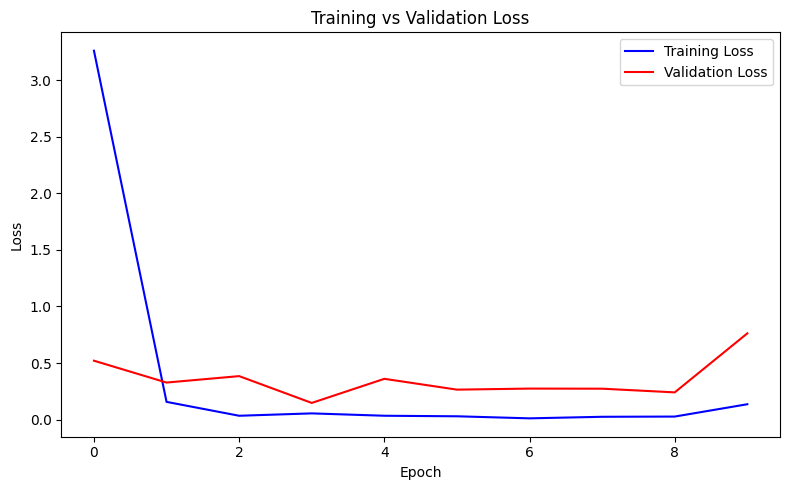

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(10)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

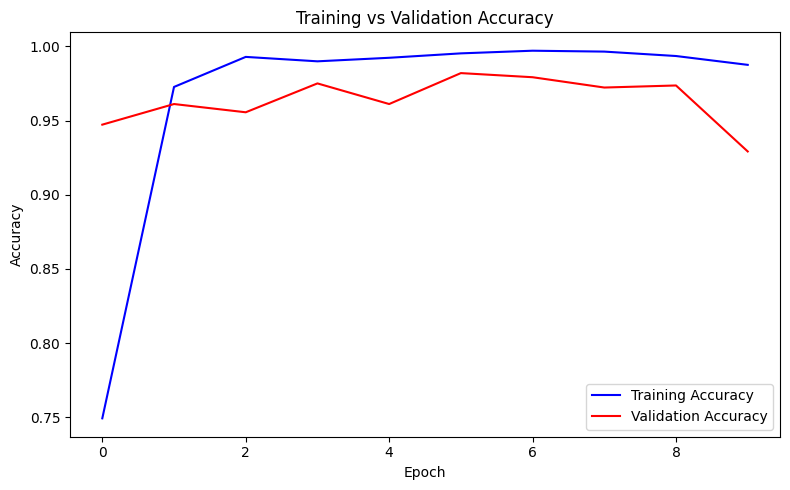

In [29]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
model.save('mobilenet_with_preprocessing.keras')